In [1]:
import nibabel as nb 
import numpy as np
import pandas as pd  
from scipy.stats import linregress, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from Functional_Fusion.dataset import decompose_pattern_into_group_indiv_noise
from scripts import decomposing_variances
from scripts import make_atlas
#from scripts import bold_normalization 
import Functional_Fusion.dataset as ds
import Functional_Fusion.atlas_map as am
from scipy.stats import ttest_1samp
from scipy.stats import t
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import Functional_Fusion.dataset as ds
import Functional_Fusion.array_convert as ac




/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_6513/2078528683.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


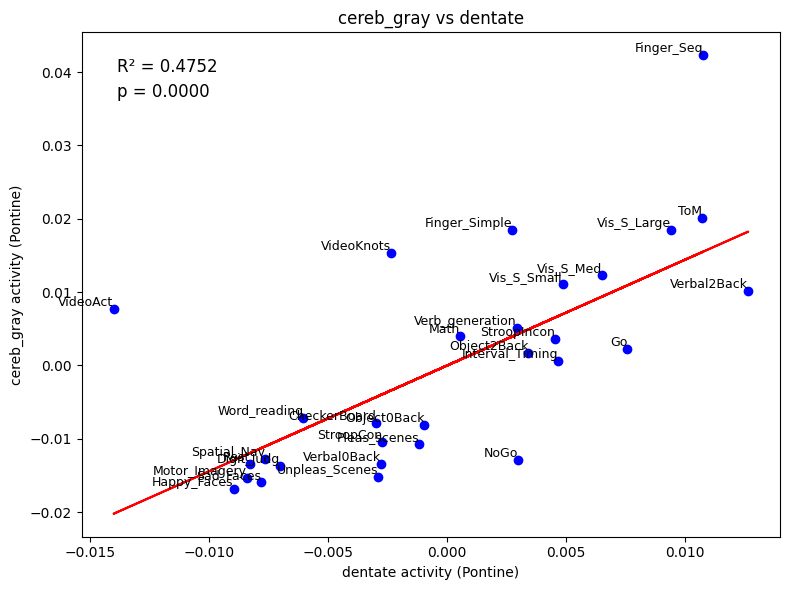

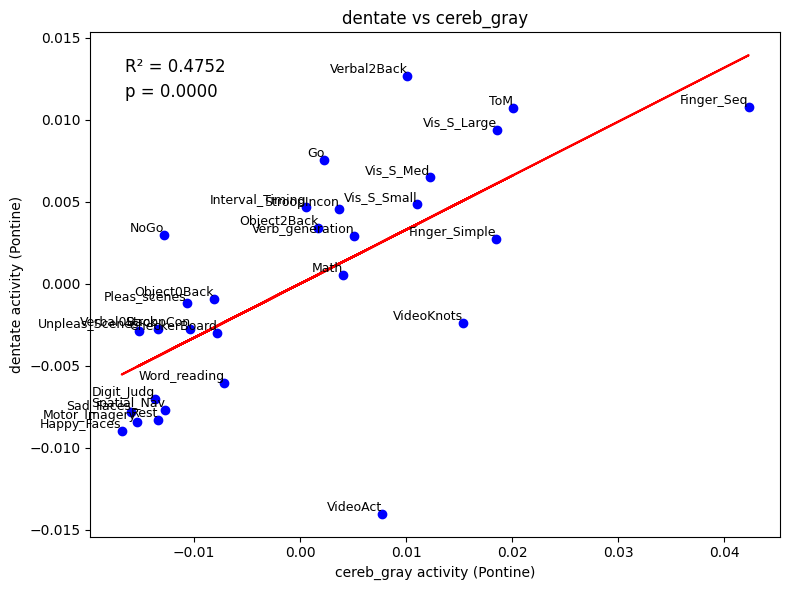

In [2]:
# group plots

df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

df = df[df["dataset"] == "MDTB"]

# List of ROI pairs to loop over
roi_pairs = [
    "cereb_gray vs dentate",
    "dentate vs cereb_gray",
    #"cereb_gray vs pontine",
    #"cereb_gray vs olive",
    #"dentate vs pontine",
    #"thalamus vs dentate",
    #"redn vs dentate",
    #"olive vs redn",
    #"dentate vs olive",
]

# Loop over each ROI pair
for roi in roi_pairs:
    roi_data = df[df['ROIs'] == roi]

    # Extract the data for plotting
    x = roi_data['x']
    y = roi_data['y']
    condition_labels = roi_data['cond']

    # Regression line parsing
    regression_line = roi_data['regression line'].iloc[0]
    slope, intercept = map(float, regression_line.split(" * x + "))

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color="blue")

    # Plot regression line
    plt.plot(x, slope * x + intercept, color="red")

    # Add labels and title
    plt.xlabel(f"{roi.split(' vs ')[1]} activity (Pontine)")
    plt.ylabel(f"{roi.split(' vs ')[0]} activity (Pontine)")
    plt.title(f"{roi}")

    # Extract statistical values
    r_squared = float(roi_data['R2'].iloc[0])
    p_value = float(roi_data['p-value'].iloc[0])

    # Display R² and p-value on the plot
    plt.text(0.05, 0.95, f"R² = {r_squared:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')
    plt.text(0.05, 0.90, f"p = {p_value:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')

    # Add condition labels to points
    for i, label in enumerate(condition_labels):
        plt.text(x.iloc[i], y.iloc[i], label, fontsize=9, color='black', ha='right', va='bottom')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
#t-tests on condition residuals to determine significant deviations from group regression line 

df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")
group_df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

df = df[df["dataset"] == "MDTB"]

# Extract all unique ROI pairs
all_rois = df['ROIs'].unique()

# Create a container for flagged results
all_flagged_results = []

# Iterate over each ROI pair
for roi_pair in all_rois:
    # Filter data for the current ROI pair
    df_filtered = df[df['ROIs'] == roi_pair]

    residuals = []

    # Loop through the unique conditions
    for condition in df_filtered['cond'].unique():
        condition_data = df_filtered[df_filtered['cond'] == condition]

        condition_residuals = []

        # Extract the GROUP regression line for this ROI and condition
        group_regression_line = group_df[(group_df['ROIs'] == roi_pair) &
                                         (group_df['cond'] == condition)]['regression line'].iloc[0]

        # Extract the slope and intercept from the group regression line
        slope, intercept = map(float, group_regression_line.split(" * x + "))

        # Loop through each subject to calculate residuals based on the group regression line
        for subj_id in condition_data['Subjects'].unique():
            subject_data = condition_data[condition_data['Subjects'] == subj_id]

            x = subject_data['x']
            y = subject_data['y']

            # Calculate predicted y-values based on the GROUP regression line
            predicted_y = slope * x + intercept

            residuals_for_subject = y - predicted_y

            # Append subject's residuals to the condition's list
            condition_residuals.append(residuals_for_subject)

        # After looping through subjects for this condition, add the residuals for this condition
        residuals.append(np.array(condition_residuals).T)  # Transpose to get subjects as rows

    # Format residuals for t-tests
    residuals = np.array(residuals).T
    residuals = residuals.squeeze()
    residuals = residuals.T  # shape is (conditions x subjects)

    # Collect t-values and p-values for t-test
    t_values = []
    p_values = []

    for i in range(residuals.shape[0]):  # Number of conditions
        t_stat, p_val = ttest_1samp(residuals[i, :], 0)
        t_values.append(t_stat)
        p_values.append(p_val)

    # Apply FDR correction
    reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.1, method='fdr_bh')

    # Store flagged results
    for i, cond in enumerate(df_filtered['cond'].unique()):
        t_stat, p_val, p_val_corrected = t_values[i], p_values[i], p_values_corrected[i]

        # Flag conditions with corrected p-value < 0.05
        flag = "Significant" if reject[i] else "Not Significant"

        all_flagged_results.append([roi_pair, cond, t_stat, p_val, p_val_corrected, flag, "MDTB"])

# Convert flagged results to DataFrame
flagged_df = pd.DataFrame(all_flagged_results,
                          columns=["ROI Pair", "Condition", "T-statistic", "P-value", 
                                   "FDR P-value", "Significance (FDR)", "dataset"])

flagged_df.to_csv('residual_t-tests.csv', mode='a', index=False)


In [ ]:
#print significant results for conditions that deviate from regression line 

file_path = "residual_t-tests.csv"  # Replace with your actual file path
df = pd.read_csv(file_path, sep=',')

# Assuming the p-values are in a column named 'p_value'
significant_rows = df[df["Significance (FDR)"] == "Significant"]

filtered_rows = significant_rows[
    (significant_rows["ROI Pair"] == "dentate vs cereb_gray") |
    (significant_rows["ROI Pair"] == "cereb_gray vs dentate")
]

# Print significant rows
print(filtered_rows)


In [ ]:
#t-tests on slopes against zero to determine significant relationship betwen ROIs 

df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

df = df[df["dataset"] == "MDTB"]


# Define the list of ROI pairs you want to include
roi_pairs = [
    #"cereb_gray vs pontine",
    #"cereb_gray vs olive",
    #"dentate vs pontine",
    #"thalamus vs dentate",
    #"redn vs dentate",
    #"olive vs redn",
   # "dentate vs olive",
    "dentate vs cereb_gray",
    "cereb_gray vs dentate"
]

# Iterate over each ROI pair
for roi_pair in roi_pairs:
    # Filter the DataFrame to only include the selected ROI pair
    df_filtered = df[df['ROIs'] == roi_pair]
    
    # Create an empty list to store the slopes for each subject
    slopes = []

    # Iterate over each subject in the filtered DataFrame
    for subj_id in df_filtered['Subjects'].unique():  # Iterate over each unique subject
        subject_data = df_filtered[df_filtered['Subjects'] == subj_id]
        
        # Extract the regression line for the subject and ROI pair
        regression_line = subject_data['regression line'].iloc[0]  # Assuming one regression line per subject/ROI pair
        
        # Extract the slope from the regression line string
        slope_str = regression_line.split(' * x')[0]  # Get the part before ' * x'
        
        # Convert the slope part to a float
        try:
            slope = float(slope_str)
        except ValueError:
            slope = None  # In case the string can't be converted to a float
        
        # Append the extracted slope to the list
        if slope is not None:
            slopes.append(slope)

    slopes_array = np.array(slopes)

    # Perform one-sample t-test on the slopes
    t_stat, p_val = ttest_1samp(slopes_array, 0)

    # Print the result for the current ROI pair
    print(f"ROI Pair: {roi_pair}")
    print(f"T-statistic: {t_stat}")#
    print(f"P-value: {p_val}")
    print("-" * 40)


In [ ]:
#ANOVA on task residuals from group regression line to determine if some tasks are better described by regression line than others

df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")
group_df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

df = df[df["dataset"] == "MDTB"]

# Extract all unique ROI pairs
all_rois = df['ROIs'].unique()

# Create containers for results
anova_results = []
tukey_results_list = []
flagged_results = []

# Iterate over each ROI pair
for roi_pair in all_rois:
    # Filter data for the current ROI pair
    df_filtered = df[df['ROIs'] == roi_pair]

    # Create an empty list to store residuals for each condition
    residuals = []

    # Loop through conditions
    for condition in df_filtered['cond'].unique():
        condition_data = df_filtered[df_filtered['cond'] == condition]

        # Extract the GROUP regression line for this ROI and condition
        group_regression_line = group_df[(group_df['ROIs'] == roi_pair) &
                                         (group_df['cond'] == condition)]['regression line'].iloc[0]

        # Extract the slope and intercept
        slope, intercept = map(float, group_regression_line.split(" * x + "))

        # Collect residuals
        condition_residuals = []

        # Loop through each subject
        for subj_id in condition_data['Subjects'].unique():
            subject_data = condition_data[condition_data['Subjects'] == subj_id]

            x = subject_data['x']
            y = subject_data['y']

            # Predicted y-values based on the group regression line
            predicted_y = slope * x + intercept
            residuals_for_subject = y - predicted_y

            condition_residuals.append(residuals_for_subject)

        residuals.append(np.array(condition_residuals).T)  # Transpose to get subjects as rows

    # Format residuals for ANOVA
    residuals = np.array(residuals).T  
    residuals = residuals.squeeze()
    residuals = residuals.T  # shape is (conditions x subjects)

    # Perform one-way ANOVA
    F_value, p_value = f_oneway(*residuals)

    # Store ANOVA results
    anova_results.append([roi_pair, F_value, p_value])

    # Tukey’s HSD
    residuals_flat = residuals.flatten()
    conditions_repeated = np.repeat(df_filtered['cond'].unique(), residuals.shape[1])

    tukey_results = pairwise_tukeyhsd(endog=residuals_flat,
                                      groups=conditions_repeated,
                                      alpha=0.05)
    tukey_results_list.append([roi_pair, tukey_results])

    # Collect t-values and p-values for t-tests
    t_values = []
    p_values = []

    for i in range(residuals.shape[0]):  # Number of conditions
        t_stat, p_val = ttest_1samp(residuals[i, :], 0)
        t_values.append(t_stat)
        p_values.append(p_val)

    # Apply FDR correction
    reject, p_values_corrected, _, _ = multipletests(p_values, alpha=0.1, method='fdr_bh')

    # Store flagged results
    for i, cond in enumerate(df_filtered['cond'].unique()):
        flagged_results.append([roi_pair, cond, t_values[i], p_values[i], p_values_corrected[i],
                                "Significant" if reject[i] else "Not Significant"])

# Convert results to DataFrames
anova_df = pd.DataFrame(anova_results, columns=["ROI Pair", "ANOVA F-value", "ANOVA P-value"])
flagged_df = pd.DataFrame(flagged_results, 
                          columns=["ROI Pair", "Condition", "T-statistic", "P-value", 
                                   "FDR P-value", "Significance (FDR)"])

# Print Results
print(anova_df)
#for roi_pair, tukey_result in tukey_results_list:
    #print(f"\nTukey's HSD for {roi_pair}:")
   # print(tukey_result)

#print("\nSignificance Results (FDR):")
#print(flagged_df)
